<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [SYNOP2] - Time series with RNN - Try a prediction
<!-- DESC --> Episode 2 : Training session and first predictions
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Make a simple prediction (3h)
 - Understanding the use of a recurrent neural network


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read our dataset
 - Select our data and normalize it
 - Doing our training
 - Making simple predictions

## Step 1 - Import and init
### 1.1 - Python

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('SYNOP2')

**FIDLE 2020 - Practical Work Module**

Version              : 0.6.1 DEV
Notebook id          : SYNOP2
Run time             : Saturday 19 December 2020, 11:22:47
TensorFlow version   : 2.0.0
Keras version        : 2.2.4-tf
Datasets dir         : /home/pjluc/datasets/fidle
Running mode         : full
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Read and prepare dataset
### 2.1 - Read it

In [38]:
dataset_dir      = './data'
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
train_len        = 25000
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- Read dataset from ./data

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Train / Test

dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
pwk.subtitle('Train dataset example :')
display(dataset_train.head(15))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

pwk.subtitle('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

pwk.subtitle('Shapes :')
print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)


<br>**Train dataset example :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,-120.0,6.0,0.0,0.0,278.75,88.0,60.0,96250.0,4.1,0.0,0.0,7.5
1,-150.0,6.0,60.0,1.0,278.65,93.0,61.0,96100.0,2.6,0.2,0.6,6.6
2,10.0,3.0,280.0,2.1,278.85,95.0,58.0,96110.0,2.6,0.0,0.4,6.4
3,230.0,3.0,310.0,2.6,279.15,96.0,50.0,96340.0,5.7,0.0,3.0,6.6
4,280.0,1.0,330.0,4.6,278.15,94.0,21.0,96620.0,8.7,0.4,0.8,5.9
5,480.0,3.0,350.0,5.1,276.95,91.0,60.0,97100.0,8.2,0.2,0.4,5.2
6,530.0,2.0,350.0,3.1,274.05,83.0,21.0,97630.0,7.2,0.0,0.0,3.5
7,450.0,2.0,340.0,6.2,272.15,81.0,2.0,98080.0,9.3,0.0,0.0,1.9
8,280.0,1.0,320.0,6.2,270.15,74.0,2.0,98360.0,10.3,0.0,0.0,1.1
9,220.0,1.0,290.0,2.6,269.65,72.0,2.0,98580.0,5.1,0.0,0.0,1.0


<br>**After normalization :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00
mean,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-6.80,-1.59,-1.75,-1.37,-5.18,-3.82,-0.52,-4.94,-1.64,-0.31,-0.27,-3.03
25%,-0.64,-0.85,-0.64,-0.76,-0.72,-0.71,-0.42,-0.55,-0.69,-0.15,-0.20,-0.75
50%,-0.00,-0.48,-0.12,-0.19,0.05,0.18,-0.42,0.03,-0.27,-0.15,-0.20,-0.01
75%,0.63,0.99,1.08,0.50,0.79,0.84,-0.37,0.61,0.52,-0.15,-0.20,0.72
max,7.16,1.36,1.34,6.28,2.40,1.62,4.46,3.10,6.29,30.36,31.27,3.02


<br>**Shapes :**

Dataset       :  (29165, 14)
Train dataset :  (25000, 12)
Test  dataset :  (4165, 12)


### 2.2 - Prepare data generator

In [39]:
sequence_len = 16
batch_size   = 32

# ---- Train generator
train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

pwk.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
pwk.subtitle('What a batch looks like (x) :')
np_print2(x[0] )
pwk.subtitle('What a batch looks like (y) :')
np_print2(y[0])

<br>**About the splitting of our dataset :**

Nombre de train batchs disponibles :  781
batch x shape :  (32, 16, 12)
batch y shape :  (32, 12)


<br>**What a batch looks like (x) :**

[[-1.089  0.623 -1.753 -1.371 -0.22   0.952  2.56  -3.502 -0.56  -0.154 -0.199 -0.64 ]
 [-1.361  0.623 -1.237 -0.964 -0.237  1.229  2.611 -3.702 -0.954  0.167  0.221 -0.75 ]
 [ 0.089 -0.482  0.654 -0.517 -0.203  1.34   2.457 -3.688 -0.954 -0.154  0.081 -0.775]
 [ 2.082 -0.482  0.912 -0.314 -0.153  1.396  2.046 -3.382 -0.14  -0.154  1.899 -0.75 ]
 [ 2.535 -1.218  1.084  0.5   -0.321  1.285  0.557 -3.009  0.648  0.488  0.36  -0.836]
 [ 4.347 -0.482  1.256  0.704 -0.522  1.118  2.56  -2.37   0.516  0.167  0.081 -0.921]
 [ 4.801 -0.85   1.256 -0.11  -1.01   0.675  0.557 -1.664  0.254 -0.154 -0.199 -1.129]
 [ 4.076 -0.85   1.17   1.151 -1.329  0.564 -0.418 -1.065  0.805 -0.154 -0.199 -1.324]
 [ 2.535 -1.218  0.998  1.151 -1.665  0.176 -0.418 -0.692  1.068 -0.154 -0.199 -1.422]
 [ 1.992 -1.218  0.74  -0.314 -1.749  0.065 -0.418 -0.399 -0.298 -0.154 -0.199 -1.434]
 [ 0.904 -1.218  1.256 -0.11  -1.615  0.453 -0.418 -0.266 -0.56  -0.154 -0.199 -1.495]
 [ 2.717 -0.482  1.256  0.704 -1.934 -0.046

<br>**What a batch looks like (y) :**

[ 0.18  -1.218  0.568 -0.761 -2.052  0.675 -0.418  0.693 -1.243 -0.154 -0.199 -1.935]


## Step 3 - Create a model

In [11]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.LSTM(100, activation='relu') )
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               45200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 46,412
Trainable params: 46,412
Non-trainable params: 0
_________________________________________________________________


# Step 4 - Compile and run

### 4.1 - Callback

In [13]:
pwk.mkdir('./run/models')
save_dir = './run/models/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.2 - Compile

In [14]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit
6' with a CPU (laptop)  
2' with a GPU

In [15]:
%%time

history=model.fit_generator(train_generator, 
                            epochs=10, 
                            verbose=1,
                            validation_data = test_generator,
                            callbacks = [bestmodel_callback])

Epoch 1/10
781/781 [==============================] - 39s 49ms/step - loss: 0.5982 - mae: 0.5025 - val_loss: 0.4670 - val_mae: 0.4259
Epoch 2/10
781/781 [==============================] - 38s 49ms/step - loss: 0.5033 - mae: 0.4368 - val_loss: 0.4431 - val_mae: 0.4058
Epoch 3/10
781/781 [==============================] - 38s 48ms/step - loss: 0.4817 - mae: 0.4189 - val_loss: 0.4261 - val_mae: 0.3870
Epoch 4/10
781/781 [==============================] - 38s 48ms/step - loss: 0.4699 - mae: 0.4088 - val_loss: 0.4176 - val_mae: 0.3818
Epoch 5/10
781/781 [==============================] - 38s 49ms/step - loss: 0.4604 - mae: 0.4013 - val_loss: 0.4106 - val_mae: 0.3738
Epoch 6/10
781/781 [==============================] - 38s 49ms/step - loss: 0.4512 - mae: 0.3962 - val_loss: 0.4073 - val_mae: 0.3690
Epoch 7/10
781/781 [==============================] - 38s 49ms/step - loss: 0.4454 - mae: 0.3923 - val_loss: 0.4077 - val_mae: 0.3703
Epoch 8/10
781/781 [==============================] - 38s 48ms

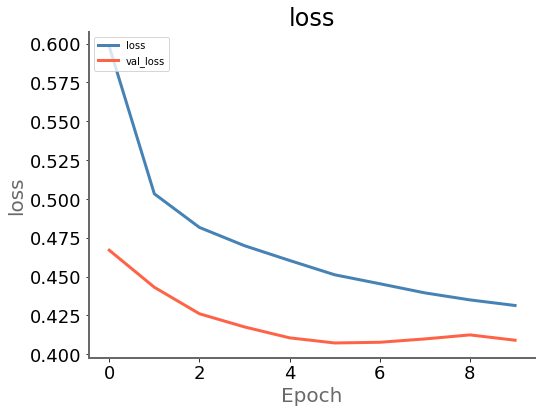

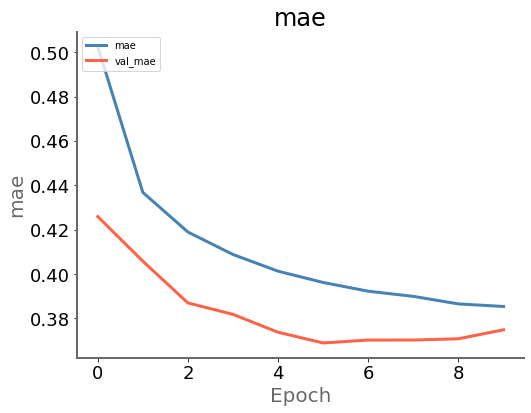

In [17]:
pwk.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='01-history')

## Step 5 - Predict

### 5.1 - Load model

In [44]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')

### 5.2 Make a prediction
A basic prediction, with normalized values (so humanly not very understandable)

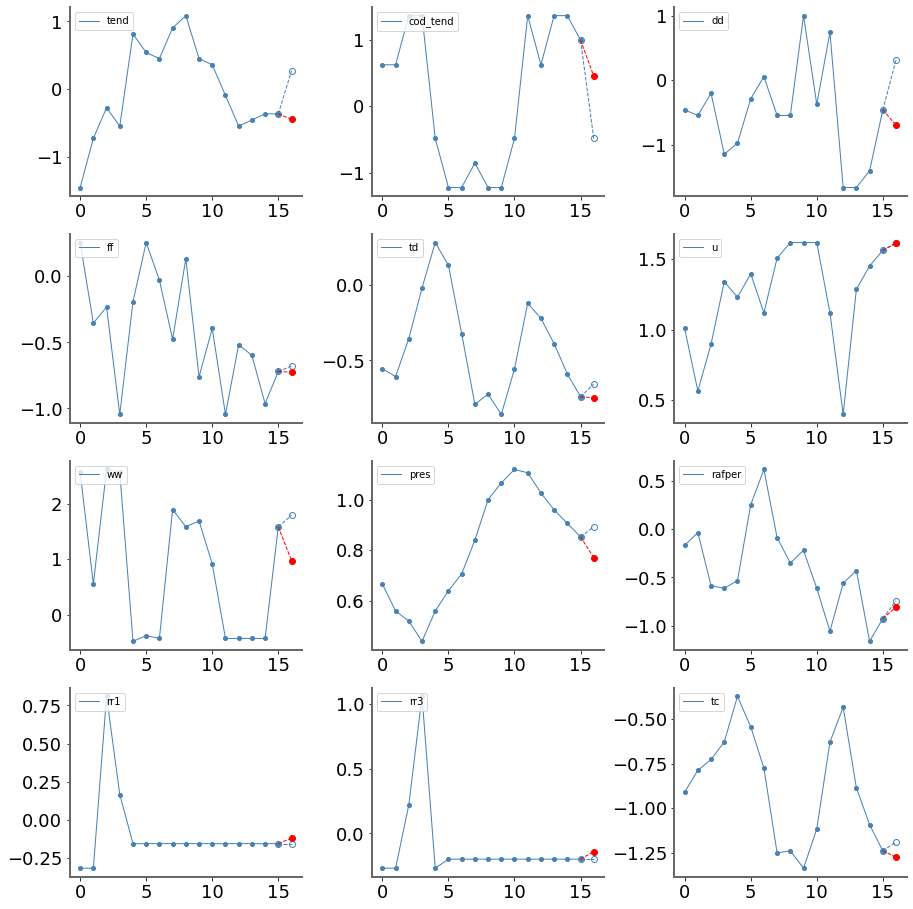

In [45]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result
pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm')


### 5.3 Real prediction
We are now going to make a true prediction, with an un-normalized result

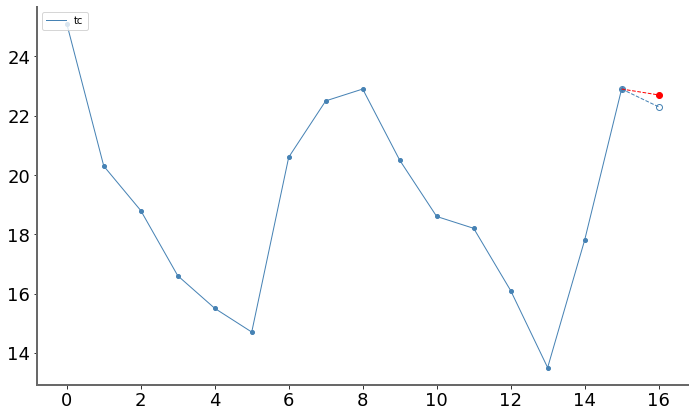

Gap between prediction and reality : 0.40 °C


In [51]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

# ---- Show it
feat=11

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8, save_as='03-prediction')

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta_deg:.2f} °C')


In [52]:
pwk.end()

End time is : Saturday 19 December 2020, 11:24:13
Duration is : 00:01:25 329ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>